# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [24]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [25]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 800 samples from 8 classes.


# Exploratory Data analysis
## Class distribution


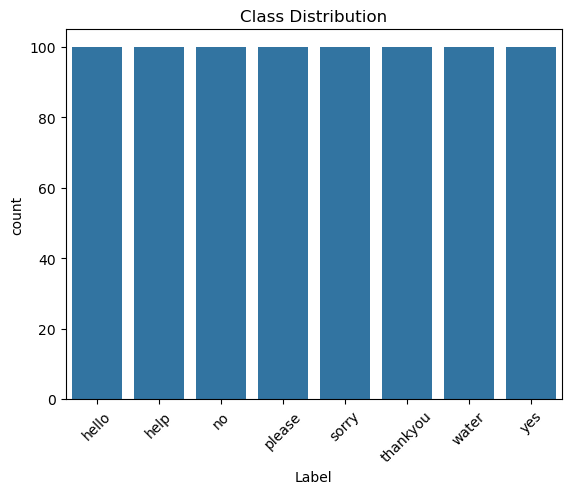

In [26]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [27]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 559, Val: 121, Test: 120


# Build model

In [29]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,384 (802.28 KB)

 Trainable params: 205,384 (802.28 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [30]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2011 - loss: 1.9840

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.2032 - loss: 1.9807 - val_accuracy: 0.6033 - val_loss: 1.4438
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4758 - loss: 1.4792

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4776 - loss: 1.4747 - val_accuracy: 0.7273 - val_loss: 0.8468
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6193 - loss: 1.0706

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6208 - loss: 1.0668 - val_accuracy: 0.8264 - val_loss: 0.5737
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7365 - loss: 0.8381

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7354 - loss: 0.8402 - val_accuracy: 0.8760 - val_loss: 0.4513
Epoch 5/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7705 - loss: 0.7089

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7717 - loss: 0.7047 - val_accuracy: 0.8595 - val_loss: 0.3297
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8319 - loss: 0.5440 - val_accuracy: 0.8760 - val_loss: 0.3679
Epoch 7/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8671 - loss: 0.4271

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8664 - loss: 0.4295 - val_accuracy: 0.9008 - val_loss: 0.2784
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8856 - loss: 0.3819 - val_accuracy: 0.9008 - val_loss: 0.2857
Epoch 9/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8884 - loss: 0.4359

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8892 - loss: 0.4307 - val_accuracy: 0.9256 - val_loss: 0.2603
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9141 - loss: 0.3206 - val_accuracy: 0.8926 - val_loss: 0.2902
Epoch 11/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8867 - loss: 0.3396

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8857 - loss: 0.3453 - val_accuracy: 0.9421 - val_loss: 0.2509
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9015 - loss: 0.3538

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9013 - loss: 0.3537 - val_accuracy: 0.9504 - val_loss: 0.1848
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9214 - loss: 0.2426 - val_accuracy: 0.8182 - val_loss: 0.6068
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9385 - loss: 0.2479

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9382 - loss: 0.2479 - val_accuracy: 0.9752 - val_loss: 0.1020
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9546 - loss: 0.1364 - val_accuracy: 0.9587 - val_loss: 0.1863
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9361 - loss: 0.1935 - val_accuracy: 0.9587 - val_loss: 0.1209
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9672 - loss: 0.1244 - val_accuracy: 0.9587 - val_loss: 0.1437
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9399 - loss: 0.1870 - val_accuracy: 0.8843 - val_loss: 0.3805
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9073 - loss: 0.3217 - val_accuracy: 0.9752 - val_loss: 0.1220
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9791 - loss: 0.0970 - val_accuracy: 0.9752 - val_loss: 0.1103
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9777 - loss: 0.0995 - val_accuracy: 0.9174 - val_l

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9607 - loss: 0.1991 - val_accuracy: 0.9835 - val_loss: 0.0981
Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9704 - loss: 0.0898 - val_accuracy: 0.9587 - val_loss: 0.1637
Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9585 - loss: 0.1233

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9588 - loss: 0.1229 - val_accuracy: 0.9917 - val_loss: 0.0870
Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9797 - loss: 0.0951 - val_accuracy: 0.9835 - val_loss: 0.0944
Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9643 - loss: 0.1277 - val_accuracy: 0.9587 - val_loss: 0.1272
Epoch 27/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9723 - loss: 0.1078 - val_accuracy: 0.9587 - val_loss: 0.1957
Epoch 28/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9720 - loss: 0.0888 - val_accuracy: 0.9669 - val_loss: 0.1584
Epoch 29/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9537 - loss: 0.1324 - val_accuracy: 0.9587 - val_loss: 0.2154
Epoch 30/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9821 - loss: 0.0682 - val_accuracy: 0.9835 - val_loss: 0.1393
Epoch 31/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9898 - loss: 0.0313 - val_accuracy: 0.9835 - val_l

# Plot training history

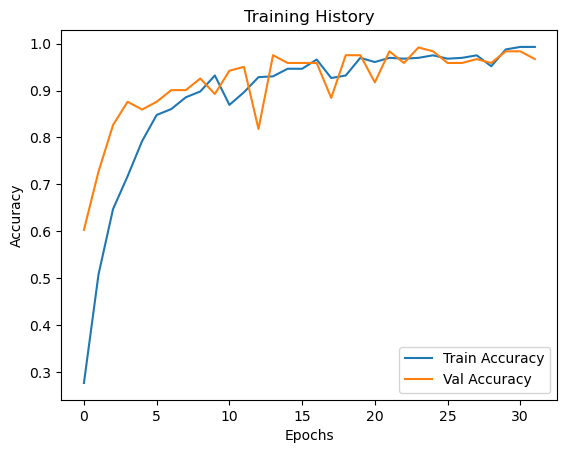

In [31]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9348 - loss: 0.2715
Test Accuracy: 0.9333


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002092BDE4720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       0.94      1.00      0.97        15
        help       1.00      0.87      0.93        15
          no       0.79      1.00      0.88        15
      please       0.93      0.93      0.93        15
       sorry       0.93      0.93      0.93        15
    thankyou       1.00      1.00      1.00        15
       water       0.93      0.93      0.93        15
         yes       1.00      0.80      0.89        15

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120



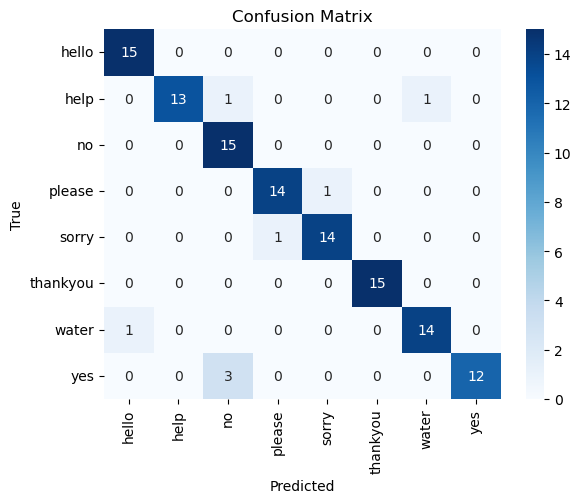

In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [33]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
